# Covid19 Analysis and Forecast for Canada (December 2020)

1. forecast of covid19 in Canada using SIR model and LSTM
2. what impacted the pandemic? study of its correlation with government policy and public behaviours
3. insights to goverment guidelines to tackle the outbreak

The analysis was performanced in December 2020 to forecast the number of cases by March 2021. It was the final exam project for MIE1624




In [ ]:
# for google colab environment
!pip install wget
!pip install covid19dh
!pip install geopandas

Required files
* time_series_covid19_confirmed_global.csv
* covid19datahub.csv
* YouGov_Covid19_Canada.csv
* gpr_000b11a_e.shp
* gpr_000b11a_e.shx

In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(0)
rn.seed(0)
tf.random.set_seed(0)
from datetime import datetime
import numpy as np
from numpy import array
import pandas as pd
import wget
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import seaborn as sns
from covid19dh import covid19
from scipy.integrate import odeint
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import geopandas as gpd
from sklearn.preprocessing import StandardScaler

In [2]:
# url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
# file = wget.download(url)
# df_raw = pd.read_csv(file)

In [3]:
df_raw = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [4]:
# cut off data after December 10 
try:
    df_raw = df_raw.loc[:,:'12/10/20']
except:
    pass

In [5]:
df_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,46516,46718,46837,46837,47072,47306,47516,47716,47851,48053
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,39014,39719,40501,41302,42148,42988,43683,44436,45188,46061
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,84152,85084,85927,86730,87502,88252,88825,89416,90014,90579
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,6790,6842,6904,6955,7005,7050,7084,7127,7162,7190
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,15251,15319,15361,15493,15536,15591,15648,15729,15804,15925


# 1. Data Cleaning

The analysis will focus on Canada

In [6]:
# extract statistics for Canada
df = df_raw[df_raw['Country/Region'] == 'Canada']
# combine each provinces' numbers to see total cases for Canada 
df = pd.DataFrame({"total":df.sum(axis=0).iloc[4:]})
# unwrangle the number of new cases from cumulated time series 
df['new'] = df.diff()
# avoid nan on first day 
df = df[1:]
# convert object to float to avoid datatype error from tensorflow 
df.new = pd.to_numeric(df.new, errors='coerce')
df.total = pd.to_numeric(df.total, errors='coerce')
# convert index to datetime
# df.index = pd.to_datetime(df.index)
df

,total,new
1/23/20,0,0
1/24/20,0,0
1/25/20,0,0
1/26/20,1,1
1/27/20,1,0
...,...,...
12/6/20,418848,6305
12/7/20,426572,7724
12/8/20,432743,6171
12/9/20,439142,6399


In [7]:
# extract number of cases from each provinces
df_prov = df_raw[df_raw['Country/Region'] == 'Canada']
# remove cruises data 
df_prov = df_prov.drop(df_prov[df_prov['Province/State'] == 'Diamond Princess'].index)
df_prov = df_prov.drop(df_prov[df_prov['Province/State'] == 'Grand Princess'].index)
df_prov = df_prov.drop(df_prov[df_prov['Province/State'] == 'Repatriated Travellers'].index)
df_prov.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20
39,Alberta,Canada,53.9333,-116.5765,0,0,0,0,0,0,...,59484,61169,63023,64851,66730,68566,70301,72028,73488,75054
40,British Columbia,Canada,53.7267,-127.6476,0,0,0,0,0,0,...,33894,34728,35422,36132,36132,36132,38152,38718,39337,40060
43,Manitoba,Canada,53.7609,-98.8139,0,0,0,0,0,0,...,17107,17384,17751,18069,18423,18806,19131,19376,19655,19947
44,New Brunswick,Canada,46.5653,-66.4619,0,0,0,0,0,0,...,508,514,520,528,530,534,536,541,542,546
45,Newfoundland and Labrador,Canada,53.1355,-57.6604,0,0,0,0,0,0,...,339,340,340,343,347,351,351,352,353,354


# 2. Data Visualization and Exploratory Data Analysis

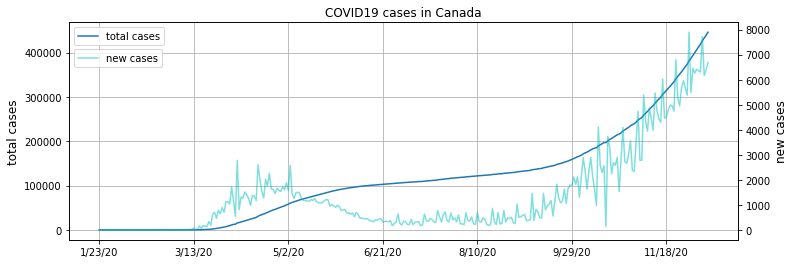

In [8]:
# plot total cases 
fig, ax = plt.subplots(1 ,1, figsize=(12,4))
ax.plot(df.total, label='total cases')
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.set_ylabel('total cases', fontsize=12)

# plot daily new cases on secondary axis 
ax2 = ax.twinx()
ax2.plot(df.new, 'c', label='new cases', alpha=0.5)
ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.set_ylabel('new cases', fontsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax.set_title('COVID19 cases in Canada')
ax.grid()
plt.show()

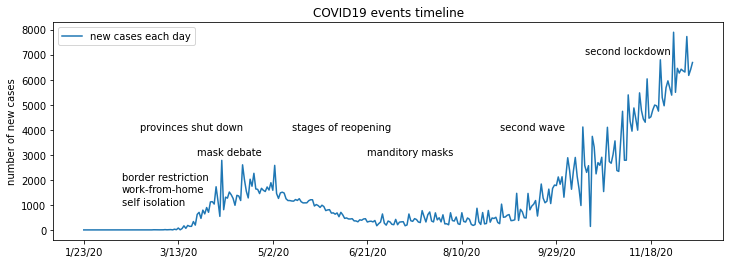

In [9]:
# plot daily cases 
fig, ax = plt.subplots(1 ,1, figsize=(12,4))
ax.plot(df.new, label='new cases each day')
ax.xaxis.set_major_locator(ticker.AutoLocator())

# plot events on timeline 
# source from 
# https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_Canada
# https://cmajnews.com/2020/06/12/coronavirus-1095847/
ax.text(20, 2000, 'border restriction')
ax.text(20, 1500, 'work-from-home')
ax.text(20, 1000, 'self isolation')
ax.text(30, 4000, 'provinces shut down')
ax.text(60, 3000, 'mask debate')
ax.text(110, 4000, 'stages of reopening')
ax.text(150, 3000, 'manditory masks')
ax.text(220, 4000, 'second wave')
ax.text(265, 7000, 'second lockdown')
ax.set_ylabel('number of new cases')
ax.set_title('COVID19 events timeline')
ax.legend()
plt.show()

In [10]:
# canada map 
# shape file from https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2011-eng.cfm
canada = gpd.read_file('gpr_000b11a_e.shp')

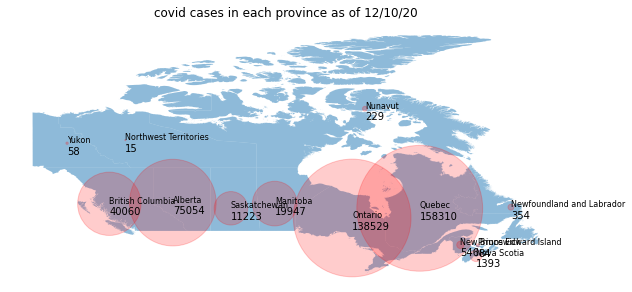

In [11]:
canada.plot(figsize=(10, 6), alpha=0.5)
plt.scatter(df_prov.Long, df_prov.Lat, zorder=1, alpha= 0.2, c='r', s=df_prov.iloc[:,-1]/10)
for i in range(df_prov.shape[0]):
    plt.text(df_prov.Long.iloc[i], df_prov.Lat.iloc[i], df_prov['Province/State'].iloc[i], fontsize=8)
    plt.text(df_prov.Long.iloc[i], df_prov.Lat.iloc[i]-2, df_prov.iloc[i, -1])
plt.title('covid cases in each province as of '+df_prov.columns[-1])
plt.axis('off')
plt.show()

# 3. Model selection and fitting to data

## SIR Model

The SIR model is famous to model infectious disease using three compartments: **Suscepible, Infected amd Recovered** population.

It is modeled as:

$\dfrac{dS}{dt} = -\beta \cdot I \cdot \frac{S}{N}$

$\dfrac{dI}{dt} = -\beta \cdot I \cdot \frac{S}{N} - \gamma \cdot I$

$\dfrac{dR}{dt} = \gamma \cdot I$

where 

S(t) = number of people susceptible on day t

I(t) = number of people infected on day t

R(t) = number of people reovered on day t

D = number of days an infection last

$\beta$ = infection rate (expected amount of people an infected person infects per day)
 = 1/D

N = total population

$\gamma$ = recovered rate (the propotion of infected people recovering per day)

---
One modification made to the base model is to model the infection rate $\beta$ as a function of time rather than a constant, because infection rate should be changing as the country intervenes and tries to stop the spreading of the virus.  

$\dfrac{dS}{dt} = -\beta(t) \cdot I \cdot \frac{S}{N}$

$\dfrac{dI}{dt} = -\beta(t) \cdot I \cdot \frac{S}{N} - \gamma \cdot I$

$\dfrac{dR}{dt} = \gamma \cdot I$


In [12]:
# function to solve the SIR ODE
def deriv(y, t, N, beta, gamma, case):
    # equations for SIR, explained above 
    S, I, R = y
    dSdt = -beta(t, case) * S * I / N
    dIdt = beta(t, case) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [13]:
# define the constants 
N = 37.59e6 # Canada populaiton 
D = 14.0 # infections lasts 14 days
gamma = 1.0 / D # recover rate 
t = np.linspace(0, 400, 400) # timeline in days 
S0, I0, R0 = N-1, 1, 0  # initial conditions: 1 person infected, rest susceptible
y0 = S0, I0, R0 

The time-dependent infection rate $\beta(t)$ is modeled with a piece-wise logistic function:
* $\beta$ starts high and starts to dive down once government starts to intervene in March
* it remains low during the lockdown period and then increase again as the country reopens
* for the future of the second wave, the function is modelled by three different curves to represent three different outcomes:
    * government takes action to control the spread right away -> $\beta$ dips down immediately
    * slower response to mitigate the spread -> delayed decrease of $\beta$
    * no action is taken to mitigate the second wave ->  $\beta$ stayed at a constant high 

In [14]:
# beta: time-depedent infection rate
# modeled with piecewise logistic functions 
def beta(t, case):
    if t<150:
        return (0.18-0.05) / (1 + np.exp(-0.1*(-t+72))) + 0.05
    elif t<250:
        return ((0.05-0.1) / (1 + np.exp(-0.1*(-t+190))) + 0.1)
    else:
        if case == 'best':
            return (0.1-0.05) / (1 + np.exp(-0.1*(-t+330))) + 0.05 #best -> take control immediately 
        elif case == 'mid':
            return (0.1-0.06) / (1 + np.exp(-0.06*(-t+360))) + 0.06 #middle ->  takes longer to response 
        elif case == 'worst':
            return 0.1  # worst case -> do nothing 

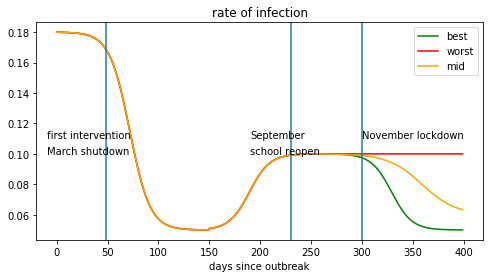

In [15]:
plt.figure(figsize=(8,4))
colors = ['g', 'r', 'orange']
cases = ['best', 'worst', 'mid']
for i, case in enumerate(cases):
    plt.plot([beta(t, case) for t in t], label=case, c=colors[i])
plt.axvline(x=48)
plt.text(-10, 0.11, 'first intervention')
plt.text(-10, 0.10, 'March shutdown')
plt.axvline(x=230)
plt.text(190, 0.11, 'September')
plt.text(190, 0.10, 'school reopen')
plt.axvline(x=300)
plt.text(300, 0.11, 'November lockdown')
plt.legend()
plt.title('rate of infection')
plt.xlabel('days since outbreak')
plt.show()

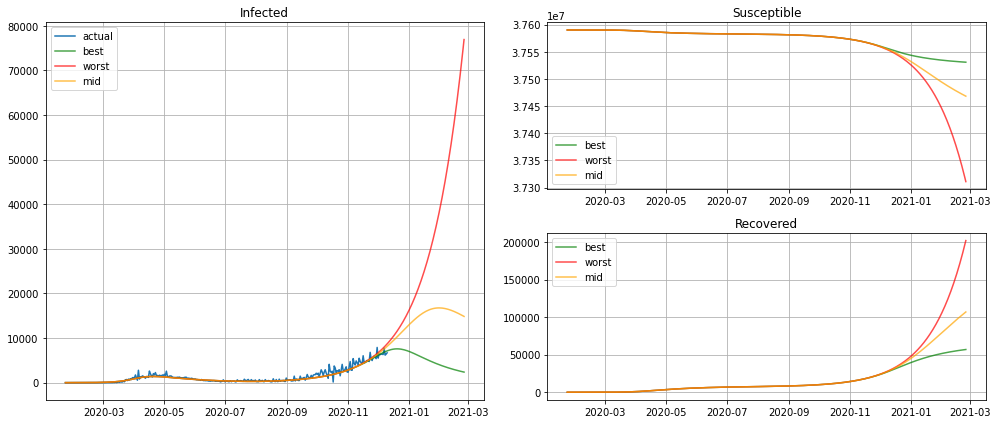

In [16]:
# compute and plot SIR models 

fig=plt.figure(figsize=(14, 6))
gs=GridSpec(2,2) 
ax1=fig.add_subplot(gs[:,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,1]) 

actual = pd.DataFrame(df.new, index=pd.date_range(start=df.index[0], periods=df.shape[0]))
ax1.plot(actual, label='actual')

for i, case in enumerate(cases):
    # compute the SIR model by solving the ODE 
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, case))
    S, I, R = ret.T
    # add dates to the results
    infected = pd.DataFrame(I, pd.date_range(start=df.index[0], periods=I.shape[0]))
    susceptible = pd.DataFrame(S, pd.date_range(start=df.index[0], periods=S.shape[0]))
    recovered = pd.DataFrame(R, pd.date_range(start=df.index[0], periods=R.shape[0]))
    
    ax1.plot(infected, label=case, c=colors[i], alpha=0.7)
    ax2.plot(susceptible, label=case, c=colors[i], alpha=0.7)
    ax3.plot(recovered, label=case, c=colors[i], alpha=0.7)

[ax.legend() for ax in [ax1, ax2, ax3]]
[ax.grid() for ax in [ax1, ax2, ax3]]
ax1.set_title('Infected')
ax2.set_title('Susceptible')
ax3.set_title('Recovered')
plt.tight_layout()

The outcome of the three models can be intepreted as:

* **best case**: immediate intervention to stop the second wave, the number of cases dives down quickly

* **worst case**: no intervention is taken, the number of cases grows exponentially and out of control

* **middle case**: delayed intervention, the peak of new cases comes at a later time, resulting a longer and bigger second wave

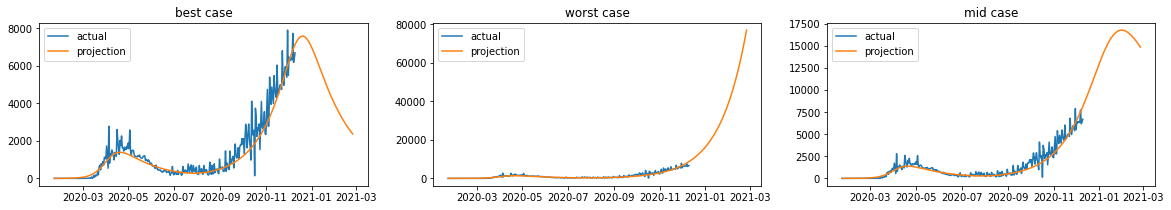

In [17]:
# zoom into the infections 
fig, ax = plt.subplots(1,3, figsize=(20,3))
cases = ['best', 'worst', 'mid']
for i, case in enumerate(cases):
    # compute the SIR model by solving the ODE 
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, case))
    S, I, R = ret.T
    actual = pd.DataFrame(df.new, index=pd.date_range(start=df.index[0], periods=df.shape[0]))
    ax[i].plot(actual, label='actual')
    infected = pd.DataFrame(I, pd.date_range(start=df.index[0], periods=I.shape[0]))
    ax[i].plot(infected, label='projection')
    ax[i].legend()
    ax[i].set_title(case+' case')

In [18]:
# normalized root mean squared error 
def nRMSE(y_pred, y_true):
    rmse = np.sqrt(((y_pred - y_true) ** 2).mean())
    return rmse/y_true.mean() 

In [19]:
print('normalized RMSE:', nRMSE(I[:df.new.shape[0]], df.new))

normalized RMSE: 0.37605367863283273


Consider the noisy input, the error rate is acceptable.

## LSTM

LSTM is also implemented to model covid cases. Using another model may bring new insights to the analysis.

For LSTM, predictions are made on a rolling basis. Past 5 days' numbers will be used to predict the next 3 days.

In [20]:
# process the time series data to input and target for supervised learning 
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequence)):
        # indexes for current sample 
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out
        # check end of sequence
        if out_end_ix > len(sequence):
            break
        # get input and target for current sample 
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
# define parameters of the model 
n_steps_in = 5 # number of days used in training 
n_steps_out = 3 # number of days to forecast 
n_features = 1 # feature=1, use daily new cases only 

In [22]:
# split time series into training and test portions 
df_train = df.iloc[:int(df.shape[0]*0.7), :]
df_test = df.iloc[int(df.shape[0]*0.7):, :]

# format data to input shapes 
X_train, y_train = split_sequence(df_train.new, n_steps_in, n_steps_out)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

X_test, y_test = split_sequence(df_test.new, n_steps_in, n_steps_out)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [23]:
# sample input: number of new cases for past 10 days
X_train[100]

array([[1583],
       [2578],
       [1453],
       [1258],
       [1479]])

In [24]:
# sample output: number of new cases for next 5 days 
y_train[100]

array([1507, 1473, 1244])

In [25]:
def train_LSTM(X, y):
    # define model architectures
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(n_steps_out))
    # train the model 
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, verbose=0)
    return model

In [26]:
# train the LSTM model with training set 
model = train_LSTM(X_train, y_train)

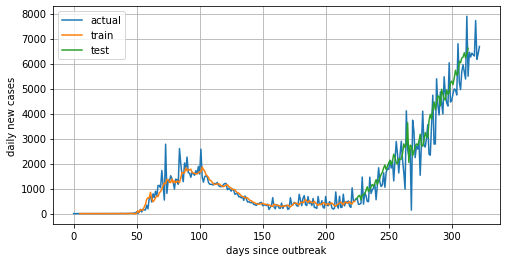

In [27]:
# make predictions
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)
pred = np.append(pred_train[:,-1], pred_test[:,-1])

plt.figure(figsize=(8,4))
plt.plot( df.new.values, label='actual')
plt.plot(np.arange(n_steps_in, n_steps_in+pred_train.shape[0]), pred_train[:,-1], label='train')
plt.plot(np.arange(n_steps_in+pred_train.shape[0], n_steps_in+pred_train.shape[0]+pred_test.shape[0]), pred_test[:,-1], label='test')
plt.ylabel('daily new cases')
plt.xlabel('days since outbreak')
plt.legend()
plt.grid()

The graph visualizes the predictions of LSTM, the model is able to capture the number of Covid cases since the predicted curve for both training and testing sets fit closely to the actual data.

In [28]:
print('training nRMSE:',  nRMSE(pred_train, y_train))
print('test nRMSE:', nRMSE(pred_test, y_test))

training nRMSE: 0.3910397094892831
test nRMSE: 0.23061558665984944


### Into the future

Current model is only predicting 3 days ahead, predicting more days will split the time series into fewer sequences, then there is not enough sets of data for the model to learn.

In order to predict for longer periods into the future, The model's outputs are fed back into the model repeatedly to simulate a long-term forecast,
in another word, prediction results are used as input to make more predictions.
The accuracy for this setup may be impractical because the input data is artificial, but the trend predicted by the model is still interesting to study the direction of the curve. 

In [29]:
# recursive function to feed output of last prediction as input of new prediction
def predict_future(model, x, n, result):
    if n > 0:
        # format input shape 
        xpred = x.reshape((1, x.shape[0], n_features))
        # make current prediction
        y = model.predict(xpred)
        # update input sequences with output 
        newX = np.append(x[1:], y.flatten()[0])
        if n == 1:
            [result.append(val) for val in y.flatten()]
        else:
            result.append(y.flatten()[0])
        n -= 1
        # make more predictions 
        return predict_future(model, newX, n, result)
    else: 
        return result 

In [30]:
result = predict_future(model, X_test[-1].flatten(), 30, [])

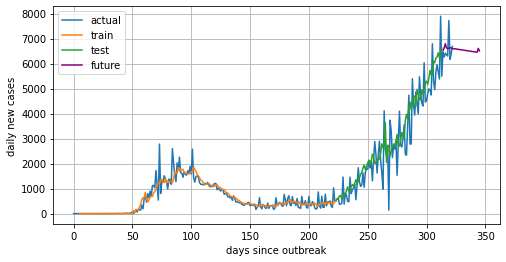

In [31]:
plt.figure(figsize=(8,4))
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)
pred = np.append(pred_train[:,-1], pred_test[:,-1])
plt.plot( df.new.values, label='actual')
plt.plot(np.arange(n_steps_in, n_steps_in+pred_train.shape[0]), pred_train[:,-1], label='train')
plt.plot(np.arange(n_steps_in+pred_train.shape[0], n_steps_in+pred_train.shape[0]+pred_test.shape[0]), pred_test[:,-1], label='test')
plt.plot(np.arange(pred.shape[0]+n_steps_in, pred.shape[0]+n_steps_in+len(result)),result, label='future', c='purple')
plt.ylabel('daily new cases')
plt.xlabel('days since outbreak')
plt.legend()
plt.grid()

The future prediction forecasts a drop of new cases. 
Intuitively, the training set (orange curve) only saw the first wave, it has learned that the number of new cases will eventually drop down, so it is predicting the same for the future (purple curve).

Outcome of this model inspires another experiment, what if the entire dataset is used for training, meaning the model will learn how the number spikes up in the second wave. 



In [32]:
# use entire dataset for training 
X, y = split_sequence(df.new, n_steps_in, n_steps_out)
X = X.reshape((X.shape[0], X.shape[1], n_features))

model2 = train_LSTM(X, y)
result = predict_future(model2, X[-1].flatten(), 30, [])

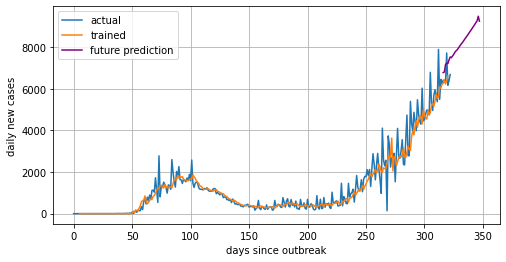

In [33]:
plt.figure(figsize=(8,4))
pred = model.predict(X)[:,-1]
plt.plot( df.new.values, label='actual')
plt.plot(np.arange(n_steps_in, n_steps_in+pred.shape[0]), pred, label='trained')
plt.plot(np.arange(pred.shape[0], pred.shape[0]+len(result)),result, label='future prediction', c='purple')
plt.ylabel('daily new cases')
plt.xlabel('days since outbreak')
plt.legend()
plt.grid()

As expected, a spike of cases is forecasted by this alternative model. The output can be explained as how the model predicts differently after learning that the number of cases can go up again. 

These two simulations can be defined as best and worst case scenario modeled by LSTM. 

# 4. Relating COVID-19 Projections to a Second Dataset

### Dataset: COVID-19 Data Hub - the Institute for Data Valorization IVADO, Canada.

This dataset contains covid data mixed with other exogenous variables to study factors that influced the spread of covid.
source:  https://covid19datahub.io/

In [34]:
# load the data from its own library 
x, src = covid19('CAN', raw=False, verbose=False) 
# x.to_csv('covid19datahub.csv')

In [35]:
x.head()

,id,date,tests,confirmed,recovered,deaths,hosp,vent,icu,population,...,currency,administrative_area_level,administrative_area_level_1,administrative_area_level_2,administrative_area_level_3,latitude,longitude,key,key_apple_mobility,key_google_mobility
11264,CAN,2020-01-01,0,0,0,0,0,0,0,37057765,...,CAD,1,Canada,NaN,NaN,44.784047,-82.508593,NaN,Canada,CA
11265,CAN,2020-01-02,0,0,0,0,0,0,0,37057765,...,CAD,1,Canada,NaN,NaN,44.784047,-82.508593,NaN,Canada,CA
11266,CAN,2020-01-03,0,0,0,0,0,0,0,37057765,...,CAD,1,Canada,NaN,NaN,44.784047,-82.508593,NaN,Canada,CA
11267,CAN,2020-01-04,0,0,0,0,0,0,0,37057765,...,CAD,1,Canada,NaN,NaN,44.784047,-82.508593,NaN,Canada,CA
11268,CAN,2020-01-05,0,0,0,0,0,0,0,37057765,...,CAD,1,Canada,NaN,NaN,44.784047,-82.508593,NaN,Canada,CA


In [36]:
# data contains interesting variables such as gathering and stay home restrictions 
x.columns

Index(['id', 'date', 'tests', 'confirmed', 'recovered', 'deaths', 'hosp',
       'vent', 'icu', 'population', 'school_closing', 'workplace_closing',
       'cancel_events', 'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'stringency_index', 'iso_alpha_3',
       'iso_alpha_2', 'iso_numeric', 'currency', 'administrative_area_level',
       'administrative_area_level_1', 'administrative_area_level_2',
       'administrative_area_level_3', 'latitude', 'longitude', 'key',
       'key_apple_mobility', 'key_google_mobility'],
      dtype='object')

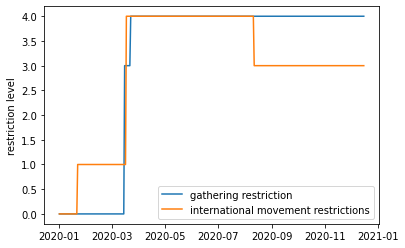

In [37]:
# visualize a few samples
# see annotation of restriction levels at https://covid19datahub.io/articles/doc/data.html
plt.plot(x.date, x.gatherings_restrictions, label='gathering restriction')
plt.plot(x.date, x.international_movement_restrictions,  label='international movement restrictions')
plt.ylabel('restriction level')
plt.legend()

In [38]:
# process the data and merge with original Johns Hopkins dataset 
x['date'] = pd.to_datetime(x.date)
df['date'] = pd.to_datetime(df.index)
df2 = df.merge(x, how='left', on='date')

# standardize the data to compute correlation 
df2.dropna(axis=1, inplace=True)
# remove string columns
df2 = df2[df2.T[df2.dtypes!=np.object].index]
date = df2.date
df2 = df2.drop(['date'], axis=1)
columns = df2.columns
scaler = StandardScaler()
df2 = scaler.fit_transform(df2)
df2 = pd.DataFrame(df2, columns=columns)
df2['date'] = date

In [39]:
df2.head()

,total,new,tests,confirmed,recovered,deaths,hosp,vent,icu,population,...,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index,iso_numeric,administrative_area_level,latitude,longitude,date
0,-1.116538,-0.812773,-1.044062,-1.112194,-1.022148,-1.492124,0.0,0.0,0.0,0.0,...,-1.995303,-2.393568,-3.685827,-0.83666,-2.277659,0.0,0.0,0.0,-1.0,2020-01-23
1,-1.116538,-0.812773,-1.044062,-1.112194,-1.022148,-1.492124,0.0,0.0,0.0,0.0,...,-1.995303,-2.393568,-3.685827,-0.83666,-2.277659,0.0,0.0,0.0,-1.0,2020-01-24
2,-1.116538,-0.812773,-1.044062,-1.112194,-1.022148,-1.492124,0.0,0.0,0.0,0.0,...,-1.995303,-2.393568,-2.309501,-0.83666,-2.277659,0.0,0.0,0.0,-1.0,2020-01-25
3,-1.116529,-0.812184,-1.044062,-1.112194,-1.022148,-1.492124,0.0,0.0,0.0,0.0,...,-1.995303,-2.393568,-2.309501,-0.83666,-2.277659,0.0,0.0,0.0,-1.0,2020-01-26
4,-1.116529,-0.812773,-1.044062,-1.112194,-1.022148,-1.492124,0.0,0.0,0.0,0.0,...,-1.995303,-2.393568,-2.309501,-0.83666,-2.277659,0.0,0.0,0.0,-1.0,2020-01-27


In [40]:
# list of viariables to investigate
measures = ['new', 'school_closing','workplace_closing', 'gatherings_restrictions', 'cancel_events', 'stay_home_restrictions', 
            'internal_movement_restrictions', 'international_movement_restrictions', 'testing_policy', 'contact_tracing']

The correlation study will focus on the second wave. For the first wave in March, all restrictions were set in at similar time,  so it is harder to distinguish single factor that contributes to the virus spread or mitigation.  However, restriction changes are more distinguishable for the second wave.

<AxesSubplot:>

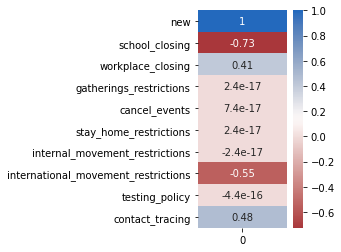

In [41]:
corr = df2.loc[df2[df2.date == '2020-06-01'].index[0]:,measures].corr() # look at correlation after June 1 to study the outbreaks after the first wave
res = np.asarray(corr.new).reshape(-1,1)
fig, ax = plt.subplots(1,1,figsize=(2,4))
sns.heatmap(res, yticklabels=measures, annot=True, cmap='vlag_r', ax=ax)

The heatmap shows school closing and international movement restrictions has the strongest negative correlation, meaning decreasing the restriction caused an increase in the number of covid outbreaks. The following timeline will visualize when each factor took place and what happened to the number of cases after that. 

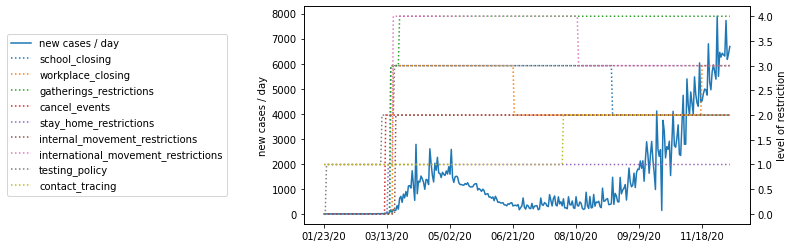

In [42]:
# revert to original scale for context 
data = df2.drop(['date'], axis=1)
columns = data.columns
data = pd.DataFrame(scaler.inverse_transform(data), columns=columns)

# plot daily new cases
fig, ax1 = plt.subplots(1,1,figsize=(8, 4))
ax1.plot(df2.date.dt.strftime('%m/%d/%y'), data.new, label='new cases / day')
ax1.set_ylabel('new cases / day')

# plot restriction timeline 
ax2 = ax1.twinx()
ax2.set_ylabel('level of restriction')
ax2.xaxis.set_major_locator(ticker.AutoLocator())
for i, measure in enumerate(measures):
    if measure != 'new':
        ax2.plot(df2.date.dt.strftime('%m/%d/%y'), data[measure], label=measure, linestyle='dotted')
fig.legend(bbox_to_anchor=(0, 0.8))

plt.show()


**Highest negative correlation:** 
increasing these restricitions would decrease the number of outbreaks, or vice vera 

school closure (-0.76)
* school reopens in September then the second wave came right after, this is a leading indicator that could be the potential cause of second wave because there are more contacts when children go to school.

international movement restrictions (-0.59)

* The border opened up in August to allow travellers from low risk regions. Again, this change happened before the second wave, so it is a leading indicator that may contributes to the second wave because travelers coming into Canada can carry the virus. 

**Highest positive correlation:**

Workplace restriction (0.26), Contact tracing (0.51)
* restriction changes happened after the number of new cases settled down or spiked up, so they are lagging indicators that act as  mitigation methods to stop covid spreading, rather than factors that influenced the severity of the outbreak. 


### Another Dataset - Imperial College London YouGov Covid 19 Behaviour Tracker Data Hub

Aside of government actions, the general public is also studied.
This dataset contains survey on people behaviour during covid regarding both physical health and psychologies. 
Examples of questions asked in the survey are the number of physical contacts one person has in one day, or one's attitude towards covid.
The datasets and surveyed questions are found at https://github.com/YouGov-Data/covid-19-tracker


In [43]:
# url = 'https://raw.githubusercontent.com/YouGov-Data/covid-19-tracker/master/data/canada.csv'
# file = wget.download(url, 'YouGov_Covid19_Canada.csv')

In [44]:
df3 = pd.read_csv('YouGov_Covid19_Canada.csv')

/Users/karenliu/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
df3.tail()

,RecordNo,endtime,qweek,i1_health,i2_health,i7a_health,i3_health,i4_health,i5_health_1,i5_health_2,...,Soc2_6,Soc2_open,vac_1,vac_2,vac2_1,vac2_2,vac2_3,vac2_4,vac2_5,vac2_6
15844,15844,24/11/2020 14:10,week 16,1,2,0,"No, I have not","No, they have not",No,No,...,Yes,Plage,5 – Strongly disagree,5 – Strongly disagree,4,1 - Strongly agree,2,4,4,3
15845,15845,24/11/2020 14:16,week 16,0,2,0,"No, I have not","No, they have not",No,No,...,,__NA__,1 - Strongly agree,1 - Strongly agree,1 - Strongly agree,5 – Strongly disagree,1 - Strongly agree,1 - Strongly agree,1 - Strongly agree,1 - Strongly agree
15846,15846,24/11/2020 14:16,week 16,1,1,1,"No, I have not","No, they have not",No,No,...,,__NA__,5 – Strongly disagree,5 – Strongly disagree,3,2,5 – Strongly disagree,5 – Strongly disagree,5 – Strongly disagree,5 – Strongly disagree
15847,15847,24/11/2020 17:30,week 16,1,2,3,"No, I have not","No, they have not",No,No,...,,__NA__,1 - Strongly agree,1 - Strongly agree,3,4,2,4,4,1 - Strongly agree
15848,15848,24/11/2020 15:47,week 16,2,3,2,"No, I have not","No, they have not",No,No,...,,__NA__,5 – Strongly disagree,5 – Strongly disagree,4,2,5 – Strongly disagree,3,3,5 – Strongly disagree


In [46]:
# extract the dates from surveys, data will be compiled to a weekly frequency 
dates = []
for i in range(1, 17):
    date = df3[df3['qweek'] == 'week '+str(i)]['endtime'].iloc[0]
    dates.append(pd.to_datetime(date,  format='%d/%m/%Y %H:%M').strftime('%m/%d/%y')) 

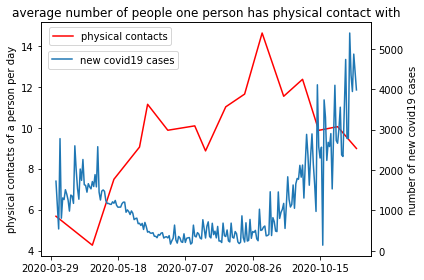

In [47]:
# question i2_health
# Not including those people in your household, about how many people have you come into physical contact with (within 2 meters / 6 feet)?


n_contact = []
# compute average value for each week 
for i in range(1, 17):
    data = df3[df3['qweek'] == 'week '+str(i)]['i2_health']
    n_contact.append(data.describe()['mean'])

# range of the dates available from YouGov dataset
df_range = df.loc['4/2/20':'11/11/20']

ax = plt.subplot()
ax2 = ax.twinx()
ax2.plot(df_range.date, df_range.new, label='new covid19 cases')
ax.plot(pd.to_datetime(dates, format='%m/%d/%y'),n_contact, c='r', label='physical contacts')
ax.legend(bbox_to_anchor=(0.41, 1))
ax2.legend(bbox_to_anchor=(0.43, 0.9))
ax.set_ylabel('physical contacts of a person per day')
ax2.set_ylabel('number of new covid19 cases')
ax.set_title('average number of people one person has physical contact with')
ax2.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.tight_layout()

The number of physical contacts was the lowest in April, later a drop of covid cases occured. Similarly the number of physical contacts was the highest in September, later a raise of covid cases occured. The direction of the curve will align if one of the curve is shifted by 2 months, therefore it conclusive that the number of physical contacts is a leading indicator that can be used to forecast the trend of covid cases. 

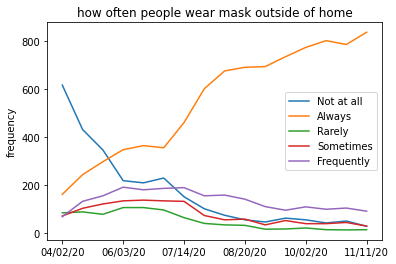

In [48]:
# question i12_health_1
# Worn a face mask outside your home (e.g. when on public transport, going to a supermarket, going to a main road)

# compute frequency of each answer 
mask_cnt = df3[df3['qweek'] == 'week '+str(1)]['i12_health_1'].value_counts()
mask = {}
for i in range(len(mask_cnt)):
    mask[mask_cnt.index[i]] = []
for i in range(1, df3['qweek'].unique().shape[0]+1):
    mask_cnt = df3[df3['qweek'] == 'week '+str(i)]['i12_health_1'].value_counts()
    for j in range(len(mask_cnt)):
        mask[mask_cnt.index[j]].append(mask_cnt[j])

ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
for key, val in mask.items():
    ax.plot(dates, val, label=key)
ax.set_title('how often people wear mask outside of home')
ax.set_ylabel('frequency')
ax.legend()  
plt.show()

The graph shows people are becoming more accepted to wearing masks. The increase in mask use is consistent, hence there was no significant incident that linked mask to the occurance of second wave. 

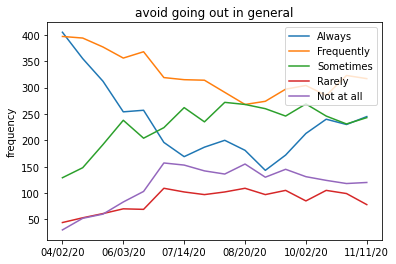

In [49]:
# question i12_health_6
# Avoided going out in general
cnt = df3[df3['qweek'] == 'week '+str(1)]['i12_health_6'].value_counts()
data = {}
for i in range(len(cnt)):
    data[cnt.index[i]] = []
for i in range(1, df3['qweek'].unique().shape[0]+1):
    cnt = df3[df3['qweek'] == 'week '+str(i)]['i12_health_6'].value_counts()
    for j in range(len(cnt)):
        data[cnt.index[j]].append(cnt[j])
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
for key, val in data.items():
    ax.plot(dates, val, label=key)
ax.set_title('avoid going out in general')
ax.set_ylabel('frequency')
ax.legend()  
plt.show()

During the start of pandemic, people are more cautious about avoiding infections, but as time went by, people have slowly lowered their guards. More people going out caused more physical contacts for the spread of the virus. This graph links back to the physical contact graph, so raising people's awareness towards preventing covid is important.


# 5. Deriving insights about policy and guidance to tackle the outbreak based on model findings

Both SIR and LSTM models indicate that actions are required immediately. With no mitigation methods implemented, the outbreak will quickly go out of control with the new number of cases growing exponentially. The main goal is to reduce the infection rate as quick as possible in order to end the second wave. 

## Cause of second wave

1. school reopening
2. more people going out

Both events created more physical contacts which increased chance of infection.

Actions are proposed to reverse them along with other methods to **reduce the infection rate**. 

## Policies and Guidance 

1. school needs to remain closed

   > Found in part 4, the dominating factor to influence the number of new cases was the school reopening. 
   >
   > Children going to school increases the chances of cross infections. They are more likely to be exposed to the virus and bring it home
   >
   > Chances of parents gaining more physical contacts are also increased when they send their kids to school and increases desire of dropping by other places along the way.

2. Keep people alerted, discourage people going out

   > stats showing people are more willing to going out compared to the beginning of the outbreak, and the graphs from part 4 also confirms that people are indeed meeting more people 
   >
   > offer more services online so there is less need to go out 
   >
   > restrict number of people in a facility: encourage appointment,  limit line ups
   >
   > limit social gathering, limit restaurant and bars 

3. implement absolute lockdown in severe areas

   > not just closing down local business and limit gathering, but restrict travelling to other cities.
   >
   > during the current soft lockdowns, people in lockdown areas are still able to travel to other cities, hence it is not effective to limit contacts. A hard lockdown is neccessary to eliminate infections in the shortest amount of time. 

4. mandatory quarantine in designated facilities for people with confirmed positive tests

   > ensure infected people will not further spread the virus

5. promote vaccines

    > reassure vaccines' safety and host media campaigns to reduce hesistancy 
    >
    > let influential figures take vaccines first to encourage the public 
    >
    > the vaccines will be the solution to eliminate infection in the long run 

6. maintain other current policies

    > what has been done need to be maintained
    >
    > people will continue to work from home, wear masks, and practice social distancing and self isolation
    >
    > border will remain closed for foreign travelers